In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import fiona as fn
import re
import requests

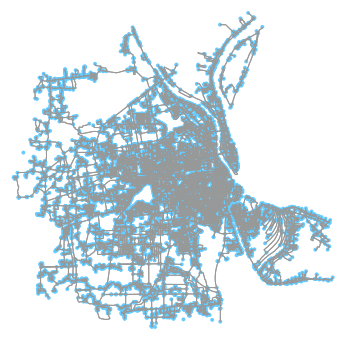

In [2]:
#Download drivable street network for "Phnom Penh, Cambodia" 
places = 'Phnom Penh, Cambodia'
G = ox.graph_from_place(places, network_type='drive', retain_all=True)
fig, ax = ox.plot_graph(G, save=True, filename='places')
#save graph to disk as shapefile
ox.save_graph_shapefile(G, filename='Phnom Penh_drivable routes')

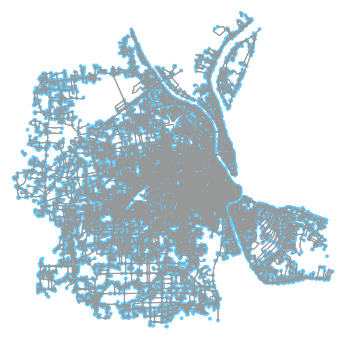

In [3]:
# Download walkable street network for "Phnom Penh, Cambodia"
places = 'Phnom Penh, Cambodia'
G = ox.graph_from_place(places, network_type='walk', retain_all=True)
fig, ax = ox.plot_graph(G, save=True, filename='places')
#save graph to disk as shapefile
ox.save_graph_shapefile(G, filename='Phnom Penh_walkable routes')

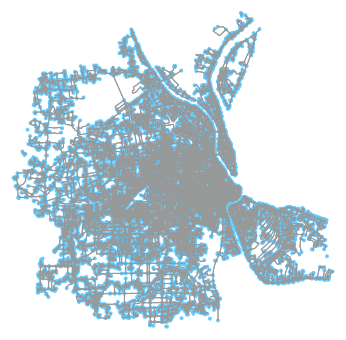

In [4]:
#Download bikable street network for "Phnom Penh, Cambodia" 
places = 'Phnom Penh, Cambodia'
G = ox.graph_from_place(places, network_type='bike', retain_all=True)
fig, ax = ox.plot_graph(G, save=True, filename='places')
#save graph to disk as shapefile
ox.save_graph_shapefile(G, filename='Phnom Penh_bikable routes')

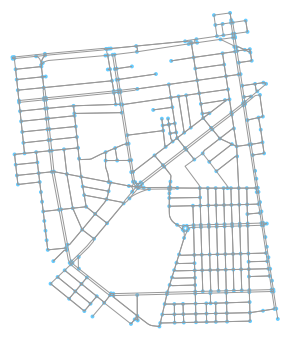

In [5]:
# you can create a drivable network with a buffer distance (meters) around the place. 
#We choose buffer_dist=200m because this place is small and don't want its extraction to cover other districts' networks.
# You can also create networks for other types of routes

G = ox.graph_from_place('Khan Prampi Makara, Cambodia', network_type='drive', buffer_dist=200)
fig, ax = ox.plot_graph(ox.project_graph(G))
graph_proj = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [7]:
# save graph to disk as shapefile (for GIS)
ox.save_graph_shapefile(G, filename='7 Makara drivable routes')

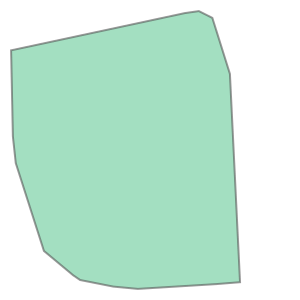

In [8]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

In [9]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                    421
m                                                                                   1081
k_avg                                                                            5.13539
intersection_count                                                                   413
streets_per_node_avg                                                              3.3943
streets_per_node_counts                   {0: 0, 1: 8, 2: 3, 3: 231, 4: 174, 5: 4, 6: 1}
streets_per_node_proportion            {0: 0.0, 1: 0.019002375296912115, 2: 0.0071258...
edge_length_total                                                                94701.5
edge_length_avg                                                                  87.6055
street_length_total                                                              58996.4
street_length_avg                                                                87.2728
street_segments_count

In [10]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(4115032233, 0.14499622329620887)

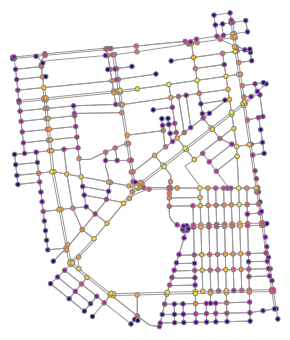

In [11]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_projected, node_color=nc, node_edgecolor='gray', node_size=20, node_zorder=2)

In [12]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G)

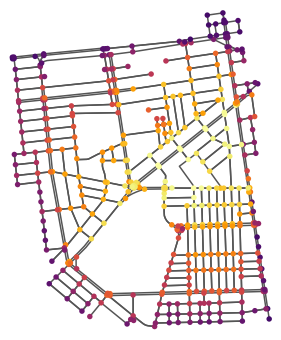

In [13]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G, bgcolor='w', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

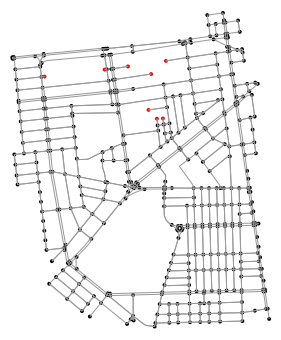

(<Figure size 361.137x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a0f789ccc0>)

In [14]:
#visualize all the cul-de-sacs (or intersections of any other type) in a city to get a sense of these points of low network connectivity
# We can visualize all the cul-de-sacs for all networks
G = ox.graph_from_place('Khan Prampi Makara, Cambodia', network_type='drive', buffer_dist=200)
culdesacs = [key for key, value in G.graph['streets_per_node'].items() if value==1]
nc = ['r' if node in culdesacs else 'none' for node in G.nodes()]
ox.plot_graph(G, node_color=nc)

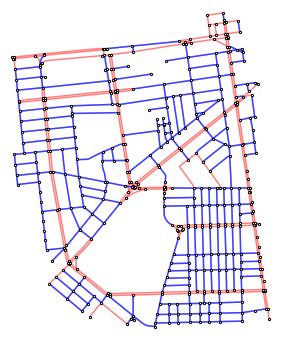

In [15]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

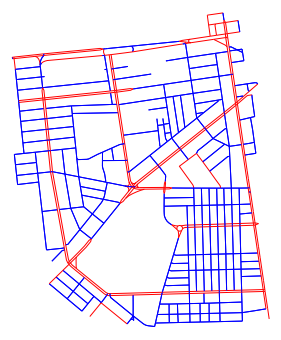

(<Figure size 361.137x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a087581198>)

In [17]:
#visualize one-way vs two-way edges to provide a sense of where a city’s one-way streets and divided roads are distributed
G = ox.graph_from_place('Khan Prampi Makara, Cambodia', network_type='drive', buffer_dist=200)
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec)

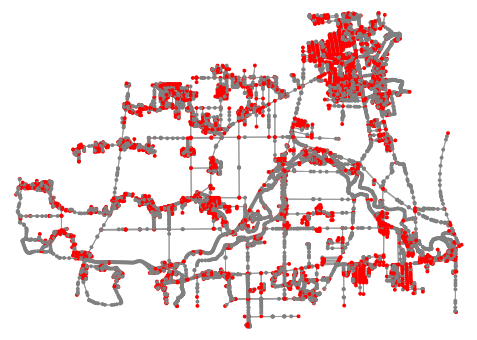

In [18]:
#visualize all the cul-de-sacs (or intersections of any other type) in a city to get a sense of these points of low network connectivity
# We can visualize all the cul-de-sacs for all networks
place = "Dangkao"
G = ox.graph_from_place(place, network_type='drive',simplify=False)
nc = ['r' if ox.is_endpoint(G, node) else 'grey' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

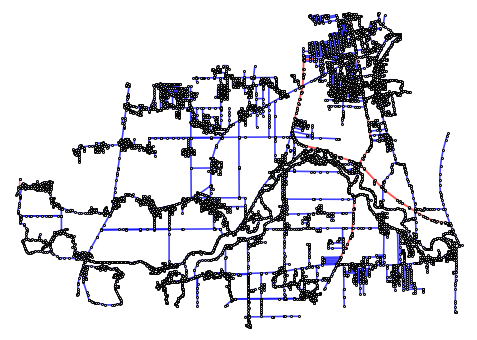

In [19]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=4, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

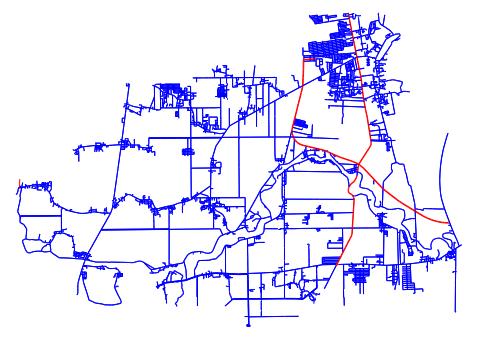

(<Figure size 626.143x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a083f739e8>)

In [20]:
#visualize one-way vs two-way edges to provide a sense of where a city’s one-way streets and divided roads are distributed
place = "Dangkao"
G = ox.graph_from_place(place, network_type='drive', simplify=False)
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec)